In [52]:
from collections import  defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import pyro
from pyro import poutine
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal
from pyro.optim import Adam

In [53]:
%load_ext autoreload
%autoreload 2
import synthesize_n400 as syn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data synthesis

In [121]:
def synthesize_dataset(size, level="word", **kwargs):
    X_word, X_phon, y = syn.sample_dataset_with_phons(size)
    X = X_word if level == "word" else X_phon
    
    epochs_df = syn.dataset_to_epochs(X, y, **kwargs)
    merged_df = pd.merge(epochs_df, X[["surprisal"]],
                         left_index=True, right_index=True)
    
    X = merged_df.surprisal.values
    y = (merged_df.value_N400 - merged_df.baseline_N400).values
    
    X = torch.tensor(X).unsqueeze(1)
    y = torch.tensor(y)
    
    return X, y

In [122]:
X, y = synthesize_dataset(10, level="phon", test_window=(.35, .45))

  0%|          | 0/10 [00:00<?, ?it/s]/home/pyromancer/workspace/shared/synthesize_n400.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_X_phon = X if acc_X_phon is None else acc_X_phon.append(X)
/home/pyromancer/workspace/shared/synthesize_n400.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_X_phon = X if acc_X_phon is None else acc_X_phon.append(X)
/home/pyromancer/workspace/shared/synthesize_n400.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_X_phon = X if acc_X_phon is None else acc_X_phon.append(X)
/home/pyromancer/workspace/shared/synthesize_n400.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  a

In [38]:
X[:5], y[:5]

(tensor([[1.1190],
         [2.4636],
         [2.6540],
         [1.8010],
         [1.3672]], dtype=torch.float64),
 tensor([ -9.6103,  -7.9983, -11.2224,  -2.7788,  -0.9863], dtype=torch.float64))

## New dataset

Testing basic discrete reindexing model.

In [108]:
N = 5
X = np.random.uniform(size=(N, 1)).astype(np.float32)
idxs = np.arange(X.shape[0])
np.random.shuffle(idxs)
coef = np.random.normal()
y = coef * X[idxs].flatten()

X = torch.tensor(X)
y = torch.tensor(y)

In [109]:
@config_enumerate
def model(X, y):
    coef = pyro.sample('coef', dist.Normal(0., 2.))
    
    with pyro.plate('data', X.shape[0]):
        index = pyro.sample('idx', dist.Categorical(torch.ones(X.shape[0])))
        
        y_hat = X[index, 0] * coef
        pyro.sample('obs', dist.Normal(y_hat, 0.1), obs=y)

In [110]:
def guide(X, y):
    coef = pyro.sample('coef', dist.Normal(0, 2))
    with pyro.plate('data', X.shape[0]):
        index = pyro.sample('idx', dist.Categorical(torch.ones(X.shape[0])))

In [111]:
pyro.clear_param_store()

elbo = TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(model, config_enumerate(guide, "parallel"), X, y)

7.7858381271362305

In [112]:
def init_loc_fn(site):
    if site["name"] == "coef":
        return torch.tensor(0.)
    elif site["name"] == "idx":
        raise NotImplementedError()
    raise ValueError(site["name"])

def initialize(X, y, seed, optim, elbo):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['coef']),
                             init_loc_fn=init_loc_fn)
    # global_guide = AutoDiagonalNormal(model)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, X, y)

In [113]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

# Choose the best among 100 random initializations.
loss, seed = min((initialize(X, y, seed, optim, elbo), seed) for seed in range(100))
initialize(X, y, seed, optim, elbo)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 0, initial_loss = -4.425904750823975


In [114]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

In [115]:
losses = []
for i in range(200):
    loss = svi.step(X, y)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

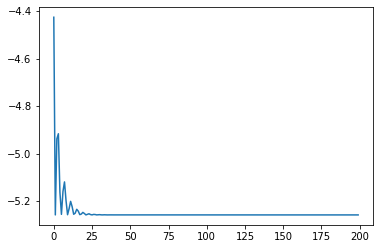

In [116]:
plt.plot(losses)

### Evaluate inferred parameters

#### `coef`

In [117]:
map_estimates = global_guide(X, y)
map_estimates["coef"]

tensor(-0.1003, grad_fn=<ExpandBackward0>)

In [118]:
coef

-0.10321885179355784

#### indexing

In [119]:
guide_trace = poutine.trace(global_guide).get_trace(X, y)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals

def classifier(X, y, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(X, y)
    return trace.nodes["idx"]["value"]

print(classifier(X, y))

tensor([1, 0, 4, 0, 2])


In [120]:
idxs

array([1, 3, 4, 0, 2])

----

In [124]:
X_word, X_phon, y = syn.sample_dataset_with_phons(1)

  0%|          | 0/1 [00:00<?, ?it/s]/home/pyromancer/workspace/shared/synthesize_n400.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/pyromancer/workspace/shared/synthesize_n400.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/pyromancer/workspace/shared/synthesize_n400.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/pyromancer/workspace/shared/synthesize_n400.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/pyromancer/workspace/shared/synthesize_n400.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/py

In [125]:
X_word

time  recognition_point  surprisal
item word_idx                                         
0    0          0.312500                  1   8.396077
     1          1.835938                  2   6.603974
     2          3.898438                  3   7.249509
     3          5.203125                  1   6.522436
     4          6.304688                  0   8.033681
     5          9.281250                  8   6.255555
     6         10.937500                  2   8.116723
     7         13.609375                  1   7.878663
     8         16.398438                  2   6.880172
     9         18.085938                  2   8.704883
     10        20.359375                  3   9.595524
     11        21.953125                  1   9.029978
     12        23.492188                  1   7.479367
     13        25.171875                  1   8.326855
     14        26.546875                  1   6.127558
     15        28.250000                  3   6.268586
     16        29.125000                  1   8.743689
     17        30.171875                  1   9.855324
     18        31.281250                  1   5.742908

In [139]:
pd.merge(X_word, X_phon, how="outer",
         left_index=True, right_index=True,
         suffixes=("_word", "_phon"))

time_word  recognition_point  surprisal_word  \
item word_idx phon_idx                                                 
0    0        0          0.312500                  1        8.396077   
              1          0.312500                  1        8.396077   
     1        0          1.835938                  2        6.603974   
              1          1.835938                  2        6.603974   
              2          1.835938                  2        6.603974   
...                           ...                ...             ...   
     18       0         31.281250                  1        5.742908   
              1         31.281250                  1        5.742908   
              2         31.281250                  1        5.742908   
              3         31.281250                  1        5.742908   
              4         31.281250                  1        5.742908   

                        time_phon  surprisal_phon  
item word_idx phon_idx                             
0    0        0          0.117188        1.795362  
              1          0.312500        2.405485  
     1        0          1.414062        1.748006  
              1          1.695312        2.259390  
              2          1.835938        0.965301  
...                           ...             ...  
     18       0         31.039062        1.331129  
              1         31.281250        2.024985  
              2         31.539062        1.146498  
              3         31.773438        2.529040  
              4         31.992188        3.891981  

[91 rows x 5 columns]

In [143]:
df = syn.dataset_to_epochs(X_phon, y)

100%|██████████| 91/91 [00:00<00:00, 448.54it/s]


In [149]:
pd.merge(X_word, df.value_N400.unstack("phon_idx").fillna(0.),
         left_index=True, right_index=True, how="inner")

time  recognition_point  surprisal          0          1  \
item word_idx                                                                  
0    0          0.312500                  1   8.396077  -9.498454 -11.892202   
     1          1.835938                  2   6.603974  -3.283434 -10.001117   
     2          3.898438                  3   7.249509  -2.261534  -3.116010   
     3          5.203125                  1   6.522436  -7.374892  -8.744459   
     4          6.304688                  0   8.033681  -9.372317   0.000000   
     5          9.281250                  8   6.255555  -2.419798  -5.876950   
     6         10.937500                  2   8.116723  -3.218387 -10.208241   
     7         13.609375                  1   7.878663  -7.288869 -11.711617   
     8         16.398438                  2   6.880172  -6.413184 -10.886603   
     9         18.085938                  2   8.704883  -3.186774 -10.920617   
     10        20.359375                  3   9.595524  -3.955260  -4.837826   
     11        21.953125                  1   9.029978  -4.813725 -11.259470   
     12        23.492188                  1   7.479367  -6.756528 -10.967714   
     13        25.171875                  1   8.326855  -8.938167 -10.234742   
     14        26.546875                  1   6.127558  -7.856416  -8.353063   
     15        28.250000                  3   6.268586  -5.554560  -5.309445   
     16        29.125000                  1   8.743689 -12.173651 -13.732021   
     17        30.171875                  1   9.855324 -14.868104 -15.563724   
     18        31.281250                  1   5.742908  -7.145315  -9.653447   

                       2          3          4         5         6          7  \
item word_idx                                                                   
0    0          0.000000   0.000000   0.000000  0.000000  0.000000   0.000000   
     1        -10.149847   0.000000   0.000000  0.000000  0.000000   0.000000   
     2         -8.485640 -11.751894  -9.924499  0.000000  0.000000   0.000000   
     3          0.000000   0.000000   0.000000  0.000000  0.000000   0.000000   
     4          0.000000   0.000000   0.000000  0.000000  0.000000   0.000000   
     5         -7.259695  -7.008339  -5.780657 -4.360475 -6.938752 -10.375285   
     6        -15.459882 -15.028444 -13.069494 -8.665042 -5.383239  -5.195922   
     7        -12.848397 -12.693284 -11.784750 -9.462616 -7.014194  -8.350686   
     8        -12.016291  -9.047271  -6.544630 -3.904430  0.000000   0.000000   
     9        -13.628889 -13.165407 -11.575119 -7.099923  0.000000   0.000000   
     10        -6.957480 -14.485481 -13.294801 -8.468297  0.000000   0.000000   
     11        -9.451511  -8.213196  -7.135996 -5.795234  0.000000   0.000000   
     12        -9.327823  -6.452655   0.000000  0.000000  0.000000   0.000000   
     13         0.000000   0.000000   0.000000  0.000000  0.000000   0.000000   
     14         0.000000   0.000000   0.000000  0.000000  0.000000   0.000000   
     15        -8.436567 -10.025222   0.000000  0.000000  0.000000   0.000000   
     16       -11.268509   0.000000   0.000000  0.000000  0.000000   0.000000   
     17         0.000000   0.000000   0.000000  0.000000  0.000000   0.000000   
     18        -8.572523  -8.902427  -7.673435  0.000000  0.000000   0.000000   

                       8          9        10  
item word_idx                                  
0    0          0.000000   0.000000  0.000000  
     1          0.000000   0.000000  0.000000  
     2          0.000000   0.000000  0.000000  
     3          0.000000   0.000000  0.000000  
     4          0.000000   0.000000  0.000000  
     5        -12.917402 -10.494814 -8.489424  
     6         -5.240963  -4.468925  0.000000  
     7         -8.681308  -7.370023 -6.144114  
     8          0.000000   0.000000  0.000000  
     9          0.000000   0.000000  0.000000  
     10         0.000000   0.000000  0.000000  
     11      